## Neural Networks with multiple layers from scratch

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from my_utils import *
%load_ext autoreload
%autoreload 2
np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the data

In [25]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


## Understand the data better
We're gonna print out the shape of the data and trying to plot have deeper look in data.

In [26]:
train_set_x_orig, y_train, test_set_x_orig, y_test, classes = load_data()
print('X Traning shape', train_set_x_orig.shape)
print('Y Traning shape', y_train.shape)
print('X test shape', test_set_x_orig.shape)
print('Y test shape', y_test.shape)
# 0 is not a cat, 1 is a cat
print('classes: ', classes)

X Traning shape (209, 64, 64, 3)
Y Traning shape (1, 209)
X test shape (50, 64, 64, 3)
Y test shape (1, 50)
classes:  [b'non-cat' b'cat']


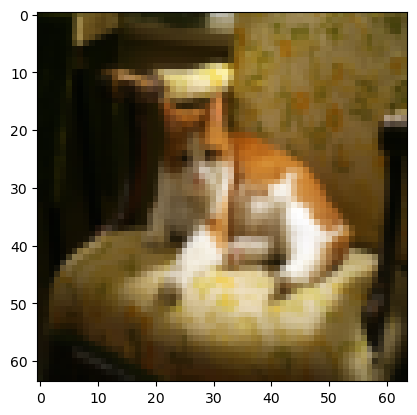

In [27]:
plt.imshow(train_set_x_orig[7])

We have m = `209` images, each image is `64x64` px. At each of a location of an image has `3` values (each value range from `0-255`) which stand for 3 channels of `RGB` color.

train_set_x_orig has shape of `(209, 64, 64, 3)`

We're going to reshape the image to only have 2 dimensions `(64x64x3, 209)`.

First we use `train_set_x_orig.reshape(m, -1)` so that it automatically reshape to `(m, 64x64x3)` which it should keep everything in order then reshape it to `(64x64x3, m)`.

In [28]:
# Get the number of training sample
m_train = train_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
m_test = test_set_x_orig.shape[0]

# Reshape the data
X_train = train_set_x_orig.reshape(m_train, -1).T
X_test = test_set_x_orig.reshape(m_test, -1).T

# Standardize data to have feature values between 0 and 1.
X_train = X_train/255.
X_test = X_test/255.


print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('First training example', X_train[:, 0])

X_train.shape (12288, 209)
X_test.shape (12288, 50)
First training example [0.06666667 0.12156863 0.21960784 ... 0.         0.         0.        ]


In [29]:
# fake data with 4 features and 5 samples
X_for_test = np.array([
    [1.50, -0.20, 0.90, 0.30, -1.0],
    [2.10, 0.60, -1.20, 0.50, 1.5],
    [-0.50, 0.40, 1.70, -0.10, -2.0],
    [0.80, 0.10, -0.70, -1.50, 0.5]
])
Y_for_test = np.array([1, 0, 1, 1, 0]).reshape(1, -1)

W_for_test = np.random.randn(4, 4) * 0.01
b_for_test = np.random.randn(4, 1)

## Initializing parameters (W, b)
This function going to use `np.random.randn` and `np.zeros` to generate W and b respectively for every layer in Neural Networks. 

We are going to multiply W by 0.1 elementwise to make W small, because we're to use sigmoid function at the end for binary classification which could make the the training process slow if the number is too big.

In [30]:
def initialize_parameters(layers_dims: list or np.ndarray): 
    parameters = {}
    np.random.seed(1)
    L = len(layers_dims)
    for l in range(1, L) : 
        # This way of initialization takes many more iterations to converge
        # parameters[f'W{l}'] = np.random.randn(layers_dims[l], layers_dims[l-1])  * 0.1
        # This way of initialization takes fewer iterations to converge
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l-1])
        parameters[f'b{l}'] = np.zeros(shape=(layers_dims[l], 1))
    return parameters
    

In [31]:
# Test initialize_parameters
parameters_for_test = initialize_parameters([4,  3, 12, 8, 2, 4, 1])

print(parameters_for_test['W1'])

[[ 0.81217268 -0.30587821 -0.26408588 -0.53648431]
 [ 0.43270381 -1.15076935  0.87240588 -0.38060345]
 [ 0.15951955 -0.12468519  0.73105397 -1.03007035]]


## Forward propagation

In [32]:
def linear_forward(A_prev, W, b): 
    '''
    A_prev (ndarray, (n_A_prev_units, m)  )
    W (ndarray,(current_n_units, prev_n_units))
    b (ndarray, (current_n_units, 1))
    '''
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)
    return Z, cache

In [33]:
def linear_forward_activation(A_prev, W, b, activation='relu'): 
    '''
    A_prev (ndarray, (n_A_prev_units, m)  )
    W (ndarray,(current_n_units, prev_n_units))
    b (ndarray, (current_n_units, 1))
    '''
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == 'relu':
        A = relu(Z)
    elif activation == 'sigmoid': 
        A = sigmoid(Z)        
        
    activation_cache = Z
    return A, (linear_cache, activation_cache)
        
A_for_test, cache = linear_forward_activation(X_for_test, W_for_test, b_for_test, activation='sigmoid')
print(cache[0][2])


[[-0.17242821]
 [-0.87785842]
 [ 0.04221375]
 [ 0.58281521]]


In [34]:
def L_model_forward(X: np.ndarray, parameters: dict): 
    '''
    parameters (dictionary): contains weights and bias for examples {W1: ..., b1: ..., ...}
    X (ndarray, (n_features, m)): training data
    '''
    L = len(parameters)//2 # since each layer has its W and b
    A = X
    caches = []
    for l in range(1, L): 
        A_prev = A
        A, cache = linear_forward_activation(A_prev, parameters[f'W{l}'], parameters[f'b{l}'])
        caches.append(cache)
        
    AL, cache = linear_forward_activation(A, parameters[f'W{L}'], parameters[f'b{L}'], activation='sigmoid')
    caches.append(cache)
    return AL, caches

A_for_test, caches = L_model_forward(X_for_test, parameters_for_test)

In [35]:
print(A_for_test)

[[0.5        0.5014019  0.51192638 0.5134527  0.5       ]]


In [36]:
def compute_cost(AL: np.ndarray, Y: np.ndarray):
    '''
    AL (ndarray, (1, m)): output of activation of the last layer (sigmoid activation func)
    Y (ndarray, (1, m)): ground true label
    '''
    m = Y.shape[1]
    sum_cost = np.dot(Y, np.log(AL).T) + np.dot(1-Y, np.log(1-AL).T)
    cost = -sum_cost/m
    cost = np.squeeze(cost)
    return cost

cost_for_test = compute_cost(A_for_test, Y_for_test)
print(cost_for_test)


0.6836842190849293


## Backward propagation

In [37]:
def linear_backward(dZ, cache: tuple): 
    A_prev, W, b = cache
    m = A_prev.shape[1]
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dW = np.dot(dZ, A_prev.T)/m
    dA_prev = np.dot(W.T, dZ) # to achieve shape (u1, m)
    return dA_prev, dW, db

In [38]:
def linear_backward_activation(dA, cache: tuple, activation):
    linear_cache, activation_cache = cache
    if activation == 'relu': 
        dZ = d_relu(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == 'sigmoid': 
        dZ = d_sigmoid(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db
    

In [39]:
def L_model_backward(AL: np.ndarray, Y: np.ndarray, caches: list): 
    '''
    caches (list [(linear_cache, activation_cache), ...])
    AL (ndarray, (1, m))
    Y (ndarray, (1, m))
    '''
    grads = {}
    L = len(caches)
    current_cache = caches[L - 1]
    # print('current_cache', len(current_cache))
    # print('current_cache', len(current_cache[0]))
    # print('current_cache', len(current_cache[1]))
    dAL = -np.divide(Y, AL) + np.divide(1-Y, 1-AL)
    dA_prev_temp, dW_temp, db_temp = linear_backward_activation(dAL, cache=current_cache, activation='sigmoid')
    grads[f'dA{L-1}'] = dA_prev_temp
    grads[f'dW{L}'] = dW_temp
    grads[f'db{L}'] = db_temp
    
    for l in reversed(range(0, L-1)): 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_backward_activation(dA_prev_temp, current_cache, activation='relu')
        grads[f'dA{l}'] = dA_prev_temp
        grads[f'dW{l+1}'] = dW_temp
        grads[f'db{l+1}'] = db_temp
    
    
    
    return grads

In [40]:
def update_parameters(parameters: dict, grads:dict, learning_rate=0.0075): 
    L = len(parameters)//2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l + 1)] - learning_rate*grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l + 1)]- learning_rate*grads["db" + str(l + 1)]
    return parameters

In [41]:

def neural_network(X, Y,layers_dims: list, num_iters: int, learning_rate=0.0075) -> (dict, list): 
    '''
    X (ndarray, (n, m)): training data
    Y (ndarray, (1, m)): ground true label
    '''
    np.random.seed(1)
    parameters = initialize_parameters(layers_dims)
    costs = []
    
    for i in range(num_iters):     
        AL, caches = L_model_forward(X, parameters)
        if i % 10 == 0: 
            costs.append(compute_cost(AL, Y))
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
    return parameters, costs

## Initializing parameters

In [42]:
num_feautures = num_px**2 *3
layers_dims = [12288, 25, 15, 8, 1] #  4-layer model
num_iters = 1000

In [43]:
parameters, costs = neural_network(X=X_train, Y=y_train, num_iters=num_iters, layers_dims=layers_dims)

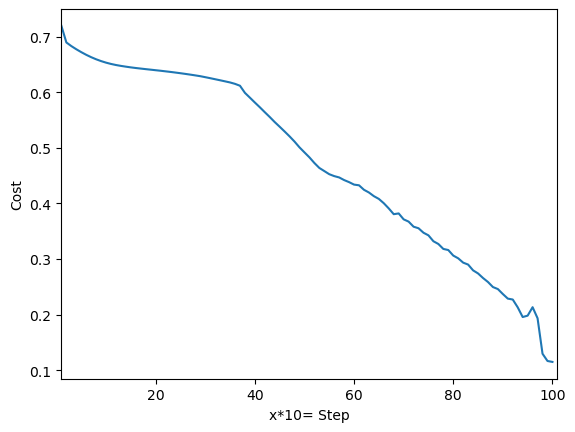

In [61]:
plt.xlabel('x*10= Step')
plt.ylabel('Cost')
plt.xlim(1, len(costs)+1)
plt.plot(range(1, len(costs) + 1), costs) 

In [75]:
def predict(X, y, parameters, title='train'):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m), dtype=int)
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print(f"Accuracy {title}: {str(np.sum((p == y)/m) * 100)}%" )
        
    return p

In [76]:
AL_test = predict(X_test, y_test, parameters, title='test')
AL_train = predict(X_train, y_train, parameters, title='train')

Accuracy test: 78.0%
Accuracy train: 98.5645933014354%


In [77]:
differece =  y_test != AL_test
wrong_prediction_indices = np.where(differece == True)[1]
print(wrong_prediction_indices)
print(y_test[:, wrong_prediction_indices])
print(AL_test[:, wrong_prediction_indices])

[ 5  6 13 18 19 28 29 34 38 44 46]
[[0 1 0 1 1 1 0 0 0 0 1]]
[[1 0 1 0 0 0 1 1 1 1 0]]


## Plot to see wrong prediction

model b'non-cat'
Ground true label:  b'cat'


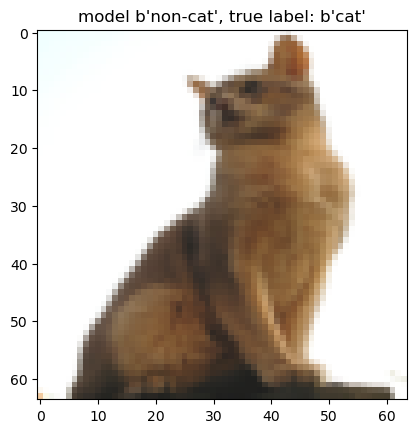

In [99]:
import random
random_wrong_image_index = random.choice(wrong_prediction_indices)
print( f'model {classes[AL_test[0, random_wrong_image_index]]}')
print('Ground true label: ', classes[y_test[0, random_wrong_image_index]])
image = X_test[:, random_wrong_image_index].reshape(num_px, num_px, 3)
plt.title(label=f'model {classes[AL_test[0, random_wrong_image_index]]}, true label: {classes[y_test[0, random_wrong_image_index]]}')
plt.imshow(image);
